In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())


Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/RATIO15_nonNorm_noaspect_128by1440_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

def predict(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
    new_h = 128
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    

In [9]:
IMAGES= ['Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
         
    

]

(128, 1536, 3)


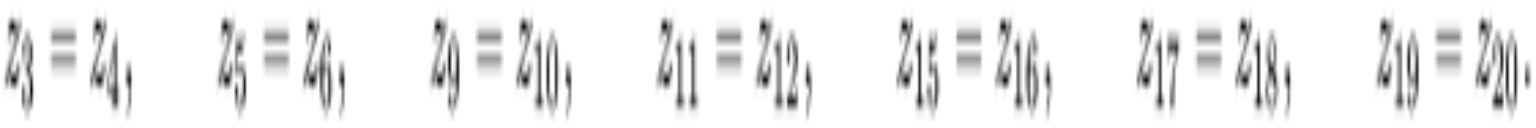

None
torch.Size([1, 128, 1536])

Predicted formula:
 <S> z _ { 3 } = z _ { 4 } , \qquad z _ { 5 } = z _ { 6 } , \qquad z _ { 9 } = z _ { 1 0 } , \qquad z _ { 1 1 } = z _ { 1 2 } , \qquad z _ { 1 5 } = z _ { 1 6 } , \qquad z _ { 1 8 } , \qquad z _ { 1 8 } , \qquad z _ { 1 8 } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 555, 3)


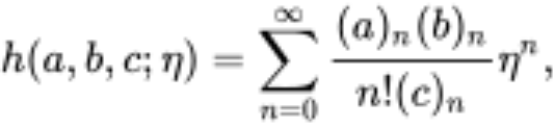

None
torch.Size([1, 128, 555])

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , \overbrace { \eta } ^ { n } , \overbrace { 9 } ^ { n } , \overbrace { 9 } \equiv 0 ! ( b ) _ { n } \equiv 0 } { 9 ! ( c ) _ { n } \equiv 0 } \eta ^ { n } , \overbrace { 9 } ^ { n } , \gamma _ { n } , <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


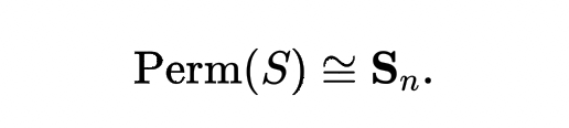

None
torch.Size([1, 128, 569])

Predicted formula:
 <S> { \bf P e r m } \Big ( S \Big ) \cong { \bf S } _ { \eta } . \qquad { \bf 9 9 } = 0 9 9 9 \qquad { \bf 9 9 } \approx { \bf 9 9 9 } \approx { \bf 9 9 9 } \approx { \bf 9 9 9 } \approx { \bf 9 6 } 9 9 9 9 \qquad { \bf 9 6 9 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 484, 3)


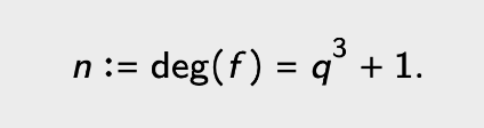

None
torch.Size([1, 128, 484])

Predicted formula:
 <S> m : = \mathrm { d e g } \big ( f \, f \, \, \, = \, \, { \bf q } ^ { 3 } \, + \, { \bf 1 } . \quad { \mathbb I } . \quad { \mathbb I } \, { \mathbb I } . \quad { \mathbb I } \, { \mathbb I } . \quad { \mathbb I } \, { \mathbb I } . \quad { \mathbb I } \, { \mathbb I } . \quad { \mathbb I } \, { \mathbb I } \, { \mathbb I } \, { \bf : = \, { \bf d e g } \big ( \, f \, f \, f \, f \, f \, f \, f


<IPython.core.display.Math object>

None
(128, 554, 3)


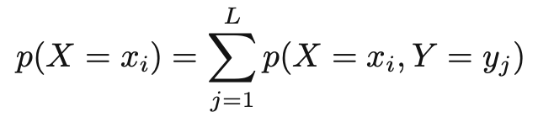

None
torch.Size([1, 128, 554])

Predicted formula:
 <S> p \Big ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p \Big ( X = x _ { i } , Y = y _ { j } \Big ) \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;


<IPython.core.display.Math object>

None
(128, 432, 3)


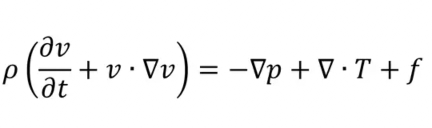

None
torch.Size([1, 128, 432])

Predicted formula:
 <S> \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \nabla p p + \nabla _ { P } + \nabla \cdot T + f ~ , \qquad \qquad \qquad \qquad \qquad \qquad \qquad G ^ { - } = - \nabla _ { P } + f \qquad \qquad \qquad \qquad \qquad \qquad \left( \frac { \partial v } { \partial t } + F + f \qquad \qquad \qquad \qquad \qquad \left( \frac { \partial v } { \partial t } + v ^ { - \nabla p } + V \ , \quad \quad \quad \left( \frac { Q y } { \partial t } + v \ \psi \ \ \ \ \ \ \ \psi \


<IPython.core.display.Math object>

None
(128, 911, 3)


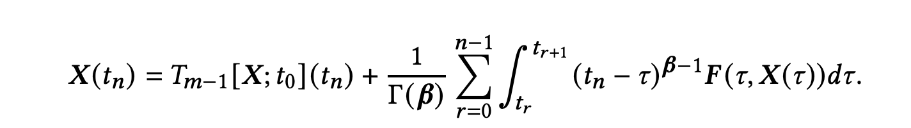

None
torch.Size([1, 128, 911])

Predicted formula:
 <S> { \bf X } ( t m ) = T _ { m - 1 } [ { \bf X } ; t _ { 0 } ] \{ t _ { m } \} + \frac { 1 } { \Gamma ( \varrho ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t r e l } ^ { t r e _ { r q } } ( t _ { n } - z ) ^ { \beta - 1 } F \left( \tau _ { i } , { \bf X } ( \tau ) \right) d \tau . \quad 0 <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1327, 3)


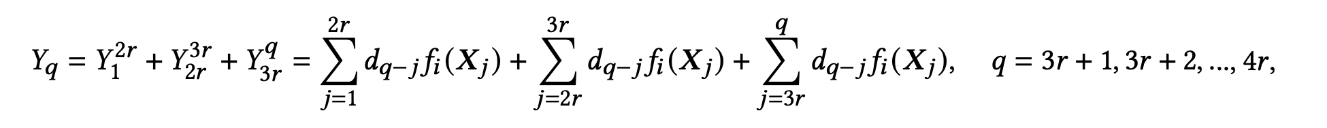

None
torch.Size([1, 128, 1327])

Predicted formula:
 <S> \Psi _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 2 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q } - j f _ { 1 } Q _ { 2 } ) + \sum _ { j = 2 r } ^ { 2 r } d _ { q } - j f _ { 4 } ( { \bf X } _ { j } ) + \sum _ { j = 3 r } ^ { q } d _ { q } ( { \bf X } j r + 1 , 3


<IPython.core.display.Math object>

None
(128, 1124, 3)


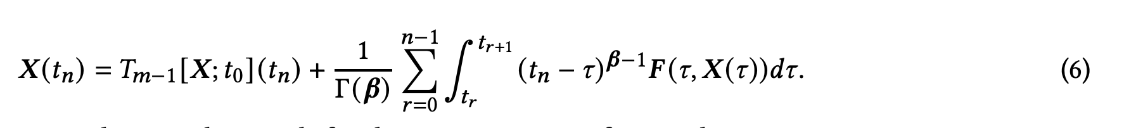

None
torch.Size([1, 128, 1124])

Predicted formula:
 <S> { \bf X } ( t _ { m - 1 } [ { \bf X } ; 6 ] ( t ) + \frac { 1 } { \Gamma ( { \cal B } ) + \frac { 1 } { \Gamma ( { \cal B } ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t r + { \bf Y } ^ { b * } } ( t _ { n } - { \bf Y } ^ { \beta - 1 } F ( { \bf r } ) d \tau . \tag { \bf B } \quad { \cal B } \quad { \cal Z } \quad { \cal Z } ( t p


<IPython.core.display.Math object>

None
(128, 270, 3)


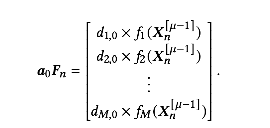

None
torch.Size([1, 128, 270])

Predicted formula:
 <S> \fbox { a o s s s G G G G G G G G G G B 2 } \\ { \mathrm { L o n g s o s o s o s o s o s e s ) } \\ { \mathrm { L o s g g s o s o s o s e s o s e s y s ) } \\ { \mathrm { l a n g s o s o s e s o s o s o s o s o s o s o s e s y s y ) } \\ { \mathrm { L o s g s o s o s o s o s o s o s e s o


<IPython.core.display.Math object>

None
(128, 582, 3)


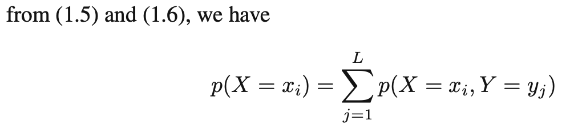

None
torch.Size([1, 128, 582])

Predicted formula:
 <S> \mathrm { ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None
(128, 768, 3)


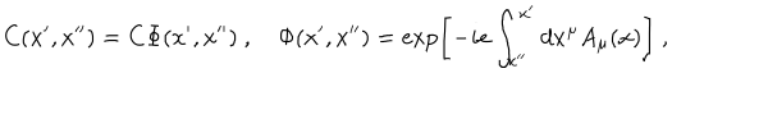

None
torch.Size([1, 128, 768])

Predicted formula:
 <S> C S ( z ^ { \prime } , { \cal K } ^ { \prime } ) = \subset \, \xi \, { \bf E } ( z ^ { \prime } ) \, = \, \Theta ( { \cal N } ^ { \prime \prime } ) = \, e _ { \cal N } \Big ( - \omega \, \Big [ - \omega \, \Big S ^ { \prime } \, { \cal A } _ { \nu } ( \varphi ) \Big ) \, \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [10]:
for image in IMAGES:
    predict(image)